# Assignment 4

#### Question 1

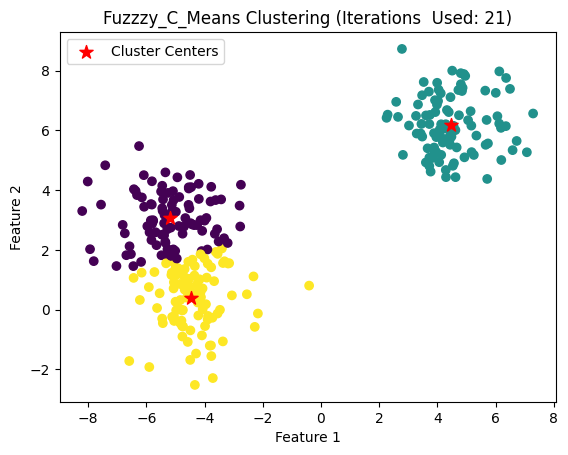

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

def fuzzy_c_means(X, c, m=2.0, max_iter=100, tol=1e-5):

    x_samples, x_features  = X.shape
    old_membership_matrix = np.zeros((x_samples,c))
    new_membership_matrix = np.zeros((x_samples,c))
    p = 0

    for  i in range(x_samples):
        row_vector = np.random.rand(c)
        normalized_row_vector = row_vector/row_vector.sum()
        old_membership_matrix[i] += normalized_row_vector
    for q in range(max_iter):
        p += 1
        cluster_center = np.zeros((c,x_features))
        for char in range(c):
             for j in range(x_features):
                numerator = 0
                denominator = 0
                for k in range(x_samples):
                    numerator += (old_membership_matrix[k,char]**m)*(X[k,j])
                    denominator += (old_membership_matrix[k,char]**m)
                cluster_center[char,j] = (numerator/denominator)\

        for i in range(x_samples):
            for j in range(c):
                denominator_1 = 0
                num = np.linalg.norm(X[i]-cluster_center[j])
                for k in range(c):
                    denominator_1 += (num/(np.linalg.norm(X[i] - cluster_center[k])))**(2/(m-1)) + 1e-10 #if any data point coincides with cluster center
                new_membership_matrix[i,j] = 1/denominator_1

        max_change = np.max(np.abs(new_membership_matrix - old_membership_matrix))
        old_membership_matrix = new_membership_matrix.copy()

        if max_change < tol:
            break
    return cluster_center,new_membership_matrix,p

X,y = make_blobs(300,centers=3)
cluster_center,new_membership_matrix,p = fuzzy_c_means(X,c= 3)
plt.scatter(X[:,0],X[:,1],c = np.argmax(new_membership_matrix,axis=1))
plt.scatter(cluster_center[:,0], cluster_center[:,1] , s = 100 , c = "red", marker = '*', label = 'Cluster Centers' )
plt.title(f"Fuzzzy_C_Means Clustering (Iterations  Used: {p})")
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


######

#### Question 2

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
image = Image.open("dog.png").convert("L")
image_arr = np.array(image)
flat_arr = image_arr.flatten()
X = flat_arr.reshape(-1,1) #As FCM expects a 2D array

Start_time = time.perf_counter()
cluster_center, membership_matrix,no_of_iter = fuzzy_c_means(X,c=3)
segmented_arr = np.zeros(flat_arr.shape)
for i in range(flat_arr.shape[0]):
    segmented_arr[i] = cluster_center[np.argmax(membership_matrix[i]),0]
segmented_image_arr = segmented_arr.reshape(image_arr.shape)
End_time = time.perf_counter()
MSE = mean_squared_error(flat_arr,(segmented_image_arr.flatten()))

print(f"Runtime: {End_time-Start_time}")
print(f"Mean Square Error: {MSE}")

fig, axes = plt.subplots(1,2)


axes[0].imshow(image_arr,cmap="grey")
axes[0].set_title("Original Image")

axes[1].imshow(segmented_image_arr,cmap="gray")
axes[1].set_title("Segmented Image")

plt.tight_layout()
plt.show()



######

#### Question 3

               Objective Function Value  Number of Iterations
Fuzziness (m)                                                
1.5                               480.3                    30
2.0                               178.6                    15
2.5                               137.5                    16
3.0                                96.6                    20
Increasing m we observe decrease in objective function


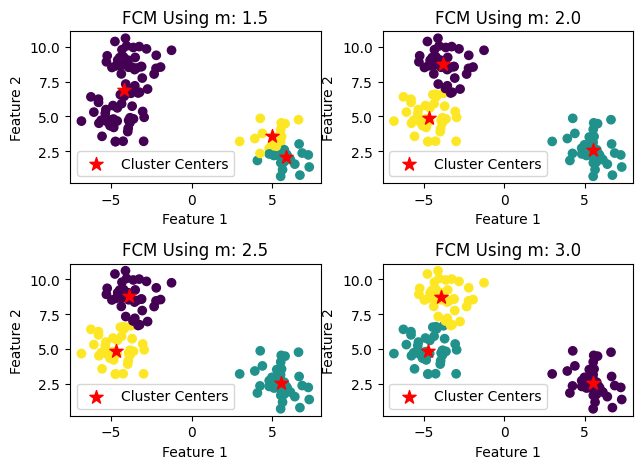

In [9]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
def objective_function_fcm(X, cluster_centers, membership_matrix, m):
    n,c = membership_matrix.shape
    J = 0
    for i in range(c):
        squared_distance = np.linalg.norm(X - cluster_centers[i],axis=1)**2
        J += np.sum((membership_matrix[:,i] ** m) * squared_distance)
    E = round(J,1)
    return float(E)

X,y = make_blobs(n_samples=120,centers=3,random_state=46)

m_list = [1.5, 2.0, 2.5, 3.0]
report = {}

fig,axes = plt.subplots(2,2)

k = 0
for m in m_list:

    cluster_center, membership_matrix, no_of_iter = fuzzy_c_means(X, c=3,m=m)
    report[m] = {
        "Objective Function Value": objective_function_fcm(X,cluster_center,membership_matrix, m),
        "Number of Iterations": no_of_iter
    }
    if k <= 1:
        axes[0][k].scatter(X[:, 0], X[:, 1], c=np.argmax(membership_matrix, axis=1))
        axes[0][k].scatter(cluster_center[:, 0], cluster_center[:, 1], s=100, c="red", marker='*',
                           label='Cluster Centers')
        axes[0][k].set_title(f"FCM Using m: {m}")
        axes[0][k].set_xlabel("Feature 1")
        axes[0][k].set_ylabel("Feature 2")
        axes[0][k].legend()

    else:
        axes[1][k-2].scatter(X[:, 0], X[:, 1], c=np.argmax(membership_matrix, axis=1))
        axes[1][k-2].scatter(cluster_center[:, 0], cluster_center[:, 1], s=100, c="red", marker='*',
                           label='Cluster Centers')
        axes[1][k-2].set_title(f"FCM Using m: {m}")
        axes[1][k-2].set_xlabel("Feature 1")
        axes[1][k-2].set_ylabel("Feature 2")
        axes[1][k-2].legend()
    k += 1



df = pd.DataFrame.from_dict(report, orient='index')
df.index.name = 'Fuzziness (m)'
print(df)

print("Increasing m we observe decrease in objective function")

plt.tight_layout()
plt.show()

######

#### Question 4

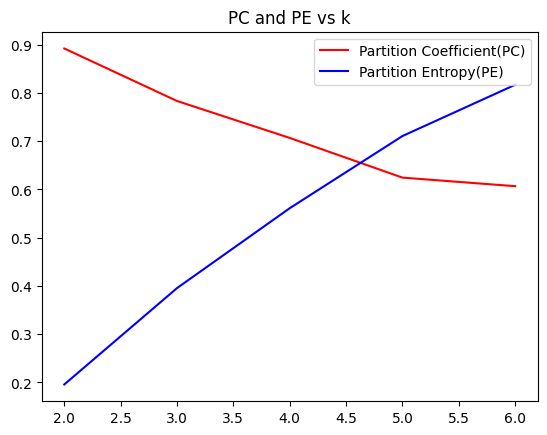

Best value of k =2, where high PC and low PE are observed


In [5]:
import skfuzzy as fuzzy
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

def partition_coefficient(membership__matrix):
    squared_matrix = np.square(membership__matrix)
    PC = np.sum(squared_matrix)/membership__matrix.shape[1]
    return PC
def partition_entropy(membership__matrix):
    c,n = membership__matrix.shape
    log_membership_matrix = np.log(membership__matrix + 1e-10) # Adding because if any membership is zero them log can't be computed.
    PE = -np.sum(membership__matrix*log_membership_matrix)/n
    return PE

iris = load_iris()
X = iris.data.T
PC_list = []
PE_list = []
k_list = [2,3,4,5,6]

for k in k_list:
    cntr, u, u0, d, jm, p, fpc = fuzzy.cluster.cmeans( data =X,c=k,m=2.0,error=1e-10,maxiter=100)
    PC_list.append(partition_coefficient(u))
    PE_list.append(partition_entropy(u))

plt.plot(k_list,PC_list,c = "red", label = "Partition Coefficient(PC)")
plt.plot(k_list,PE_list,c = "blue", label = "Partition Entropy(PE)")
plt.title("PC and PE vs k")
plt.legend()
plt.show()

print("Best value of k =2, where high PC and low PE are observed")


######

#### Question 5

ARI: 0.04004201114564011


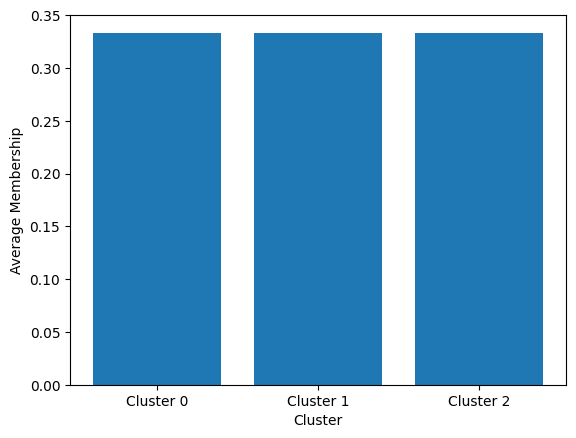

In [6]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import skfuzzy as fuzzy
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
categories = ["rec.autos", "sci.space", "talk.politics.misc"]

required_data_generation = fetch_20newsgroups(categories = categories,remove = ('headers', 'footers', 'quotes'))

data = required_data_generation.data[:3000]
y_true = required_data_generation.target[:3000]

vectorizer = TfidfVectorizer(stop_words="english",max_features=5000)
vectorized_matrix = vectorizer.fit_transform(data)

reducing_agent = TruncatedSVD(n_components=50,random_state=42)
data_reduced = reducing_agent.fit_transform(vectorized_matrix)

cntr, u, u0, d, jm, p, fpc = fuzzy.cluster.cmeans(data=data_reduced.T,c=3,m=2.0,error=0.005,maxiter=1000)
predicted_targets = np.argmax(u,axis=0)

ARI = adjusted_rand_score(y_true,predicted_targets)
print(f"ARI: {ARI}")

average_membership = np.mean(u,axis=1)

cluster_indices = ["Cluster 0", "Cluster 1", "Cluster 2"]

plt.bar(cluster_indices,average_membership)
plt.xlabel("Cluster")
plt.ylabel("Average Membership")
plt.show()